In [1]:
PATH_ROOT = '../data'
PATH_OUTPUT = '../output'
PATH_PARQUET = PATH_ROOT + '/project_datasets'
PATH_QUOTEBANK = PATH_ROOT + '/Quotebank'
PATH_TO_QUOTES = PATH_QUOTEBANK + '/quotes-{year}.json.bz2'

In [2]:
!pip install pyarrow

In [3]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import seaborn as sns

#NLP libraries
import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim_models

import matplotlib.pyplot as plt
%matplotlib inline 

import pickle

C:\Users\steph\miniconda3\envs\ada\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# 1. Loading speakers data

### Reading speakers parquet file

In [4]:
%%time

df_speakers_original = pd.read_parquet(PATH_PARQUET + '/speaker_attributes.parquet')
df_speakers_original.set_index(keys='id', inplace=True)
df_speakers_original

Wall time: 17.7 s


,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,label,candidacy,type,religion
id,,,,,,,,,,,,,,
Q23,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,George Washington,"[Q698073, Q697949]",item,[Q682443]
Q42,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[Q145],[Q6581097],1395737157,[Q7994501],None,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,None,Douglas Adams,None,item,None
Q1868,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Q31],[Q6581097],1380367296,None,None,"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q...",None,None,Paul Otlet,None,item,None
Q207,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[Q30],[Q6581097],1395142029,None,None,"[Q82955, Q15982858, Q18814623, Q1028181, Q1408...",[Q29468],None,George W. Bush,"[Q327959, Q464075, Q3586276, Q4450587]",item,"[Q329646, Q682443, Q33203]"
Q297,"[Velázquez, Diego Rodríguez de Silva y Velázqu...",[+1599-06-06T00:00:00Z],[Q29],[Q6581097],1391704596,None,None,[Q1028181],None,None,Diego Velázquez,None,item,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q106406560,[Barker Howard],None,[Q30],[Q6581097],1397399351,None,None,[Q82955],None,None,Barker B. Howard,None,item,None
Q106406571,[Charles Macomber],None,[Q30],[Q6581097],1397399471,None,None,[Q82955],None,None,Charles H. Macomber,None,item,None
Q106406588,None,[+1848-04-01T00:00:00Z],None,[Q6581072],1397399751,None,None,None,None,None,Dina David,None,item,None


In [5]:
df_speakers_cleaned = df_speakers_original.dropna()
print('Total number of speakers : ', len(df_speakers_original))
print('Total number of speakers with filled attributes : ', len(df_speakers_cleaned))
print('{} rows dropped'.format(len(df_speakers_original) - len(df_speakers_cleaned)))

Total number of speakers :  9055981
Total number of speakers with filled attributes :  3
9055978 rows dropped


As we can see that **dropping all speakers with undefined attributes is unrealistic to work with**, since we're only left with 3 speakers with all their attributes defined to work with. We're going to have to some fine-grained filtering of undefined values column wise instead of on whole rows (all attributes).

# 2. Preprocessing speakers data

Speakers attributes are stored as qids of their actual labels in the wikidata provided. We need to replace these qids with their labels to be able to get any information out of them, and we do this by merging on the qids.

### Reading wikidata labels

In [6]:
df_wikidata_labels = pd.read_csv(PATH_PARQUET + '/wikidata_labels_descriptions_quotebank.csv.bz2', compression='bz2', index_col='QID')
df_wikidata_labels.head()

,Label,Description
QID,,
Q31,Belgium,country in western Europe
Q45,Portugal,country in southwestern Europe
Q75,Internet,global system of connected computer networks
Q148,People's Republic of China,sovereign state in East Asia
Q155,Brazil,country in South America


### Merging speakers attributes with wikidata labels

**Some columns store their values as lists**, such as a speaker who has multiple occupations or nationalities. We need to **explode** those so that we have a row for each unique value in each column.

In [7]:
attributes_columns_to_be_labeled = ['nationality', 'gender', 'ethnic_group', 'occupation', 'party', 'academic_degree', 'candidacy', 'religion']

def merge_on_qid(df_speakers, df_wikidata, col):
    '''
    Merge speakers attributes with their labels from the wikidata. 
    
    Params:
        df_speakers: the speakers dataframe with attributes as qids
        df_wikidata: the wikidata dataframe that maps qids to their attributes
        col: the column we're merging on
    
    Returns:
        the speakers dataframe with the given column merged with their label
    '''
    # explode on the given column to have a single value for that column in each row
    df_attribute_exploded = df_speakers.explode(col)
    
    # Merge on the column with the wikidata, replacing qid with the label
    df_attribute_labeled = df_attribute_exploded.merge(df_wikidata_labels, left_on=col, right_index=True, how='left')
    df_attribute_labeled[col] = df_attribute_labeled['Label']
    df_attribute_labeled.drop(columns=['Label', 'Description'], inplace=True)
    
    # Revert the explosion by bringing the exploded values back to list
    df_speakers[col] = df_attribute_labeled[col].groupby(by='id').agg(list)
    
    return df_speakers

In [8]:
%%time

df_speakers_labeled = df_speakers_original.copy()
for col in attributes_columns_to_be_labeled:
    df_speakers_labeled = merge_on_qid(df_speakers_labeled, df_wikidata_labels, col)
    
df_speakers_labeled

Wall time: 15min 32s


,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,label,candidacy,type,religion
id,,,,,,,,,,,,,,
Q23,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Great Britain, United States of America]",[male],1395141751,[nan],W000178,"[politician, military officer, farmer, cartogr...",[independent politician],[nan],George Washington,"[1792 United States presidential election, 178...",item,[Episcopal Church]
Q42,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[United Kingdom],[male],1395737157,[White British],None,"[playwright, screenwriter, novelist, children'...",[nan],[nan],Douglas Adams,[nan],item,[nan]
Q1868,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Belgium],[male],1380367296,[nan],None,"[writer, lawyer, librarian, information scient...",[nan],[nan],Paul Otlet,[nan],item,[nan]
Q207,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[United States of America],[male],1395142029,[nan],None,"[politician, motivational speaker, autobiograp...",[Republican Party],[nan],George W. Bush,"[2000 United States presidential election, 200...",item,"[United Methodist Church, Episcopal Church, Me..."
Q297,"[Velázquez, Diego Rodríguez de Silva y Velázqu...",[+1599-06-06T00:00:00Z],[Spain],[male],1391704596,[nan],None,[painter],[nan],[nan],Diego Velázquez,[nan],item,[nan]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q106406560,[Barker Howard],None,[United States of America],[male],1397399351,[nan],None,[politician],[nan],[nan],Barker B. Howard,[nan],item,[nan]
Q106406571,[Charles Macomber],None,[United States of America],[male],1397399471,[nan],None,[politician],[nan],[nan],Charles H. Macomber,[nan],item,[nan]
Q106406588,None,[+1848-04-01T00:00:00Z],[nan],[female],1397399751,[nan],None,[nan],[nan],[nan],Dina David,[nan],item,[nan]


In [9]:
len(df_speakers_labeled) == len(df_speakers_original)

True

### Quick stop before proceeding: determining speaker's age

Before we continue, we need to convert the date of birth to something meaningful like the speaker's age. To avoid tedious computations using *datetime* and carefully considering *None* values on the month and day of birth, we're only going to approximate the age by doing calculations **based only on the year of birth** (which is good enough for our purposes).

In [10]:
# Let's explode the date of birth
df_age_exploded = df_speakers_labeled.explode('date_of_birth')
# Keep only the first birthdate for speakers with multiple birthdates
df_age_exploded = df_age_exploded[~df_age_exploded.index.duplicated(keep='first')]
df_age_exploded

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,label,candidacy,type,religion
id,,,,,,,,,,,,,,
Q23,"[Washington, President Washington, G. Washingt...",+1732-02-22T00:00:00Z,"[Great Britain, United States of America]",[male],1395141751,[nan],W000178,"[politician, military officer, farmer, cartogr...",[independent politician],[nan],George Washington,"[1792 United States presidential election, 178...",item,[Episcopal Church]
Q42,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",+1952-03-11T00:00:00Z,[United Kingdom],[male],1395737157,[White British],None,"[playwright, screenwriter, novelist, children'...",[nan],[nan],Douglas Adams,[nan],item,[nan]
Q1868,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",+1868-08-23T00:00:00Z,[Belgium],[male],1380367296,[nan],None,"[writer, lawyer, librarian, information scient...",[nan],[nan],Paul Otlet,[nan],item,[nan]
Q207,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",+1946-07-06T00:00:00Z,[United States of America],[male],1395142029,[nan],None,"[politician, motivational speaker, autobiograp...",[Republican Party],[nan],George W. Bush,"[2000 United States presidential election, 200...",item,"[United Methodist Church, Episcopal Church, Me..."
Q297,"[Velázquez, Diego Rodríguez de Silva y Velázqu...",+1599-06-06T00:00:00Z,[Spain],[male],1391704596,[nan],None,[painter],[nan],[nan],Diego Velázquez,[nan],item,[nan]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q106406560,[Barker Howard],None,[United States of America],[male],1397399351,[nan],None,[politician],[nan],[nan],Barker B. Howard,[nan],item,[nan]
Q106406571,[Charles Macomber],None,[United States of America],[male],1397399471,[nan],None,[politician],[nan],[nan],Charles H. Macomber,[nan],item,[nan]
Q106406588,None,+1848-04-01T00:00:00Z,[nan],[female],1397399751,[nan],None,[nan],[nan],[nan],Dina David,[nan],item,[nan]


In [11]:
def get_year_of_birth(date):
    '''
    Helper function to extract the year of birth of the speaker from the format we're given.
    
    Params:
        date: the date of birth in the given format (e.g. '+1732-02-22T00:00:00Z')
    Returns:
        the year of birth
    '''
    if date:
        return int(date[1:5])
    else:
        return date
    
test_data = '+1732-02-22T00:00:00Z'
get_year_of_birth(test_data)

1732

In [12]:
# Normalize date of birth into a new column 'age' in which we'll calculate the age of the speaker
df_speakers_labeled['age'] = df_age_exploded.date_of_birth.apply(get_year_of_birth)

# Calculate the age by computing the difference between now and their birth dates.
now = pd.Timestamp('now')
df_speakers_labeled.age = (now.year - df_speakers_labeled.age)
df_speakers_labeled.head()

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,label,candidacy,type,religion,age
id,,,,,,,,,,,,,,,
Q23,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Great Britain, United States of America]",[male],1395141751,[nan],W000178,"[politician, military officer, farmer, cartogr...",[independent politician],[nan],George Washington,"[1792 United States presidential election, 178...",item,[Episcopal Church],289.0
Q42,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[United Kingdom],[male],1395737157,[White British],None,"[playwright, screenwriter, novelist, children'...",[nan],[nan],Douglas Adams,[nan],item,[nan],69.0
Q1868,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Belgium],[male],1380367296,[nan],None,"[writer, lawyer, librarian, information scient...",[nan],[nan],Paul Otlet,[nan],item,[nan],153.0
Q207,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[United States of America],[male],1395142029,[nan],None,"[politician, motivational speaker, autobiograp...",[Republican Party],[nan],George W. Bush,"[2000 United States presidential election, 200...",item,"[United Methodist Church, Episcopal Church, Me...",75.0
Q297,"[Velázquez, Diego Rodríguez de Silva y Velázqu...",[+1599-06-06T00:00:00Z],[Spain],[male],1391704596,[nan],None,[painter],[nan],[nan],Diego Velázquez,[nan],item,[nan],422.0


**Note**: of course ages are just indicative, we can have people like president George Washington who are over 200 years old.

#### Let's also categorize each speaker by their age group

For example, are they in their 20s, 30s or 70s.

In [13]:
def get_age_group(age):
    '''
    Return the age group based on the age as a string. For people between 10 and 100 years old
    we just keep the tens of the value (e.g. 75 -> '70s', 20 -> '20s'). 
    For people more than 100 years old we output '>100'
    For people less than 10 years old we output '<10'
    
    Params:
        age: the age
    Returns 
        the age group in string format
    '''
    if age is None or np.isnan(age):
        return age
    elif age < 10:
        return '<10'
    elif age >= 100 :
        return '>=100'
    else:
        return str(int(age / 10) * 10) + 's'

df_speakers_labeled['age_group'] = df_speakers_labeled.age.apply(get_age_group)
df_speakers_labeled

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,label,candidacy,type,religion,age,age_group
id,,,,,,,,,,,,,,,,
Q23,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Great Britain, United States of America]",[male],1395141751,[nan],W000178,"[politician, military officer, farmer, cartogr...",[independent politician],[nan],George Washington,"[1792 United States presidential election, 178...",item,[Episcopal Church],289.0,>=100
Q42,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[United Kingdom],[male],1395737157,[White British],None,"[playwright, screenwriter, novelist, children'...",[nan],[nan],Douglas Adams,[nan],item,[nan],69.0,60s
Q1868,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Belgium],[male],1380367296,[nan],None,"[writer, lawyer, librarian, information scient...",[nan],[nan],Paul Otlet,[nan],item,[nan],153.0,>=100
Q207,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[United States of America],[male],1395142029,[nan],None,"[politician, motivational speaker, autobiograp...",[Republican Party],[nan],George W. Bush,"[2000 United States presidential election, 200...",item,"[United Methodist Church, Episcopal Church, Me...",75.0,70s
Q297,"[Velázquez, Diego Rodríguez de Silva y Velázqu...",[+1599-06-06T00:00:00Z],[Spain],[male],1391704596,[nan],None,[painter],[nan],[nan],Diego Velázquez,[nan],item,[nan],422.0,>=100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q106406560,[Barker Howard],None,[United States of America],[male],1397399351,[nan],None,[politician],[nan],[nan],Barker B. Howard,[nan],item,[nan],NaN,NaN
Q106406571,[Charles Macomber],None,[United States of America],[male],1397399471,[nan],None,[politician],[nan],[nan],Charles H. Macomber,[nan],item,[nan],NaN,NaN
Q106406588,None,[+1848-04-01T00:00:00Z],[nan],[female],1397399751,[nan],None,[nan],[nan],[nan],Dina David,[nan],item,[nan],173.0,>=100


### Checking final dataframe

In [14]:
display(df_speakers_labeled)
display(df_speakers_labeled.dtypes)
print('Length of final labeled speakers dataframe {}'.format(len(df_speakers_labeled)))

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,label,candidacy,type,religion,age,age_group
id,,,,,,,,,,,,,,,,
Q23,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Great Britain, United States of America]",[male],1395141751,[nan],W000178,"[politician, military officer, farmer, cartogr...",[independent politician],[nan],George Washington,"[1792 United States presidential election, 178...",item,[Episcopal Church],289.0,>=100
Q42,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[United Kingdom],[male],1395737157,[White British],None,"[playwright, screenwriter, novelist, children'...",[nan],[nan],Douglas Adams,[nan],item,[nan],69.0,60s
Q1868,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Belgium],[male],1380367296,[nan],None,"[writer, lawyer, librarian, information scient...",[nan],[nan],Paul Otlet,[nan],item,[nan],153.0,>=100
Q207,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[United States of America],[male],1395142029,[nan],None,"[politician, motivational speaker, autobiograp...",[Republican Party],[nan],George W. Bush,"[2000 United States presidential election, 200...",item,"[United Methodist Church, Episcopal Church, Me...",75.0,70s
Q297,"[Velázquez, Diego Rodríguez de Silva y Velázqu...",[+1599-06-06T00:00:00Z],[Spain],[male],1391704596,[nan],None,[painter],[nan],[nan],Diego Velázquez,[nan],item,[nan],422.0,>=100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q106406560,[Barker Howard],None,[United States of America],[male],1397399351,[nan],None,[politician],[nan],[nan],Barker B. Howard,[nan],item,[nan],NaN,NaN
Q106406571,[Charles Macomber],None,[United States of America],[male],1397399471,[nan],None,[politician],[nan],[nan],Charles H. Macomber,[nan],item,[nan],NaN,NaN
Q106406588,None,[+1848-04-01T00:00:00Z],[nan],[female],1397399751,[nan],None,[nan],[nan],[nan],Dina David,[nan],item,[nan],173.0,>=100


aliases                object
date_of_birth          object
nationality            object
gender                 object
lastrevid               int64
ethnic_group           object
US_congress_bio_ID     object
occupation             object
party                  object
academic_degree        object
label                  object
candidacy              object
type                   object
religion               object
age                   float64
age_group              object
dtype: object

Length of final labeled speakers dataframe 9055981


In [15]:
df_speakers_labeled[df_speakers_labeled.label == 'Donald Trump']

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,label,candidacy,type,religion,age,age_group
id,,,,,,,,,,,,,,,,
Q22686,"[Donald John Trump, Donald J. Trump, Trump, Th...",[+1946-06-14T00:00:00Z],[United States of America],[male],1395141850,[nan],None,"[business magnate, investor, restaurateur, non...","[Republican Party, Independence Party of Ameri...",[Bachelor of Science],Donald Trump,"[2016 United States presidential election, 202...",item,[Presbyterianism],75.0,70s
Q27947481,"[Donald L. Trump, Donald Lynn Trump, Skip Trum...","[+1945-07-31T00:00:00Z, +1945-00-00T00:00:00Z]",[United States of America],[male],1392088288,[nan],None,"[physician, oncologist]",[nan],[Doctor of Medicine],Donald Trump,[nan],item,[nan],76.0,70s


Now all attributes are meaningfully labeled with their labels from the wikidata and we can start analysis.

# 3 - Save result to disk for quick future retrieval

In [16]:
df_speakers_labeled.to_parquet(PATH_OUTPUT + '/speakers_labeled.parquet.gzip', compression='gzip')

# 4. Analysis on speakers data 

## Caveat

To be able to do any analysis, it's easier to work with columns that don't have values as lists. We can simply explode all these attributes as we did previously. So for each speaker, we **explode all their attributes** so that each row contains attributes that have only one value in them (so not a list).

However, there is **one important issue with this approach**. for speakers with several attributes that have multiple values in them (e.g. a speaker with several occupations and several genders, etc...) **the explosion of one attribute may affect the overall distribution of another attribute in the original data**. For example, a speaker in the original data that has as *gender* 'transexual' and as *occupation* both 'politician' and 'basketball player', will appear twice in the final exploded dataframe, once as 'politician' and once as 'basketball player', however in both rows he will be 'transexual' and this means 'transexual' will be counted twice, meaning the distribution of gender in the final dataframe will not be the same as the one in the original dataframe.  

Also when training a model using the exploded features, speakers with several attributes that have multiple values will have more weights, since they 

So the answer is yes: distributions will differ but by how much and will it affect the final result greatly? 
Let's do some analysis on the speaker's *occupation* and try to compare **exploding all attributes vs exploding only the attribute in question**.

In [17]:
# Retrieve the preprocessed dataframe
retrieved_labeled_speakers = pd.read_parquet(PATH_OUTPUT + '/speakers_labeled.parquet.gzip')
display(retrieved_labeled_speakers)
display(retrieved_labeled_speakers.dtypes)
print('Length of final labeled speakers dataframe {}'.format(len(retrieved_labeled_speakers)))

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,label,candidacy,type,religion,age,age_group
id,,,,,,,,,,,,,,,,
Q23,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Great Britain, United States of America]",[male],1395141751,[None],W000178,"[politician, military officer, farmer, cartogr...",[independent politician],[None],George Washington,"[1792 United States presidential election, 178...",item,[Episcopal Church],289.0,>=100
Q42,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[United Kingdom],[male],1395737157,[White British],None,"[playwright, screenwriter, novelist, children'...",[None],[None],Douglas Adams,[None],item,[None],69.0,60s
Q1868,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Belgium],[male],1380367296,[None],None,"[writer, lawyer, librarian, information scient...",[None],[None],Paul Otlet,[None],item,[None],153.0,>=100
Q207,"[George Walker Bush, Bush Jr., Dubya, GWB, Bus...",[+1946-07-06T00:00:00Z],[United States of America],[male],1395142029,[None],None,"[politician, motivational speaker, autobiograp...",[Republican Party],[None],George W. Bush,"[2000 United States presidential election, 200...",item,"[United Methodist Church, Episcopal Church, Me...",75.0,70s
Q297,"[Velázquez, Diego Rodríguez de Silva y Velázqu...",[+1599-06-06T00:00:00Z],[Spain],[male],1391704596,[None],None,[painter],[None],[None],Diego Velázquez,[None],item,[None],422.0,>=100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q106406560,[Barker Howard],None,[United States of America],[male],1397399351,[None],None,[politician],[None],[None],Barker B. Howard,[None],item,[None],NaN,None
Q106406571,[Charles Macomber],None,[United States of America],[male],1397399471,[None],None,[politician],[None],[None],Charles H. Macomber,[None],item,[None],NaN,None
Q106406588,None,[+1848-04-01T00:00:00Z],[None],[female],1397399751,[None],None,[None],[None],[None],Dina David,[None],item,[None],173.0,>=100


aliases                object
date_of_birth          object
nationality            object
gender                 object
lastrevid               int64
ethnic_group           object
US_congress_bio_ID     object
occupation             object
party                  object
academic_degree        object
label                  object
candidacy              object
type                   object
religion               object
age                   float64
age_group              object
dtype: object

Length of final labeled speakers dataframe 9055981


In [18]:
df_occupation_exploded = retrieved_labeled_speakers.explode('occupation')

attributes_columns_to_be_labeled = ['nationality', 'gender', 'ethnic_group', 'occupation', 'party', 'academic_degree', 'candidacy', 'religion']
df_all_attributes_exploded = retrieved_labeled_speakers.copy()
for col in attributes_columns_to_be_labeled:
    df_all_attributes_exploded = df_all_attributes_exploded.explode(col)

In [19]:
# Top 10 occupations in the dataframe where we exploded all attributes 
grouped_by_occupations_all_exploded = df_all_attributes_exploded.groupby(by='occupation').label.agg(['count'])
grouped_by_occupations_all_exploded = grouped_by_occupations_all_exploded.sort_values(by='count', ascending=False)

# Top 10 occupations in the dataframe where we exploded just 'occupation'
grouped_by_occupations_occupation_exploded = df_occupation_exploded.groupby(by='occupation').label.agg(['count'])
grouped_by_occupations_occupation_exploded = grouped_by_occupations_occupation_exploded.sort_values(by='count', ascending=False)

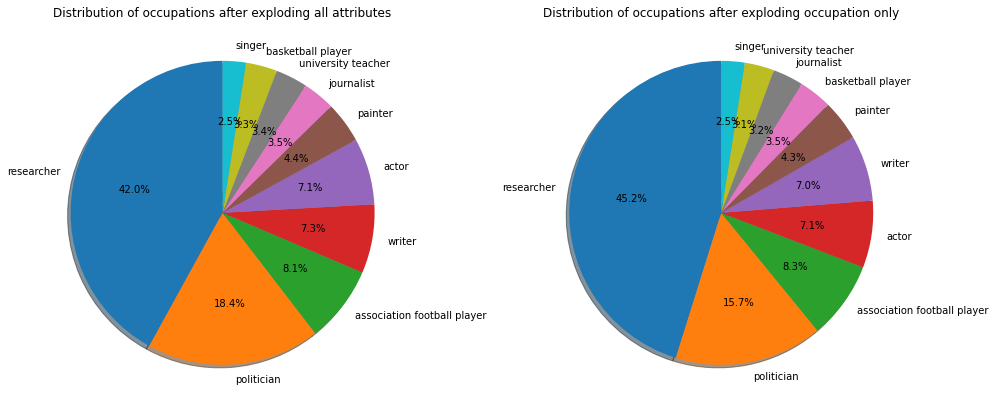

In [20]:
# Compare the distribution of the top 10 occupations between both dataframes
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize =  (14, 8))
ax1.pie(grouped_by_occupations_all_exploded[:10]['count'], labels=grouped_by_occupations_all_exploded[:10].index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.set_title('Distribution of occupations after exploding all attributes')

ax2.pie(grouped_by_occupations_occupation_exploded[:10]['count'], labels=grouped_by_occupations_occupation_exploded[:10].index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax2.set_title('Distribution of occupations after exploding occupation only')

fig.tight_layout()

We can see that the distribution may more or less change, but the top 10 occupations stay the same. However **since we only exploded *occupation*** the right chart represents the real distribution of occupations.

**So the final rule of thumb is**: only explode attributes that we're using as features or doing analysis on, to minimize distortions in the original distributions.

# 5. Extra